# Set Up
## Import

In [1]:
import numpy as np
from numba import jit, prange, njit, vectorize
import pandas
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time

## Settings

In [11]:
#CAUTION: if R is chosen too small and N too high, then when the program will try to calculate the inverse of dGr
# in the calculation of the saturated density profile, the following error will show: 'Matrix singular to numerical precision.'
# for example, for R=0.75, N=1000 is too high.  
R=0.75#cm
H=0.2 #cm
N=500
M=200
position_of_electrons=100

hr=R/N
hz=H/M

e=4.80324e-10

N_Vib=np.round(0.4/hr)
N_Vmb=np.round(0.57/hr)
N_Vob = np.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)

eps=1e-10
GreenFuncName = f"GreenFunction/Green_njit_R{str(R).replace('.', 'pt')}_H{str(H).replace('.', 'pt')}_N{N}_M{M}_posiE{position_of_electrons}_epsE{int(np.log10(eps))}.npy" 

# Define Functions

In [5]:
iRange = np.arange(2, N+1)

@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = np.full((M+1,N+1),-1/300)
fitil = np.full((M+1,N+1),-1/300)
aStart = np.zeros((M-1, N+1))
a = np.zeros((M-1, N+1))

def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    
    
    np.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    #err = np.zeros((M+1, N+1))
    
    count = 0
    errHere = 1e-10
    print(count)
    np.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        np.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)



        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(np.abs(fitil[1:M, 0:N+1] - a))


    return fitil
    



In [17]:
preCalcDisStat = np.arange(1, N+1)


@jit(nopython = True, fastmath=True, parallel=True)
def distribSTATIC(R,H,N,M,G,Ertil,dGr,radius_of_electron_pool):

    dens = np.zeros(N+1)
    dens[:int(radius_of_electron_pool)+1] = np.dot(Ertil[:int(radius_of_electron_pool)+1], np.linalg.inv(dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]))

    A = np.zeros(N+1)

    A[0] = np.pi * np.power((hr/2), 2)
    A[N] = np.pi *(N - 5/4) * np.power(hr, 2)
    A[0:N] = 2 * np.pi * (preCalcDisStat - 1) * np.power(hr, 2)
    
    temp = A[0:len(dens)] * dens[0:len(dens)]
    
    N_total = np.sum(temp)
    
    return dens, N_total, A, temp

# Calculations

## Load Green Function

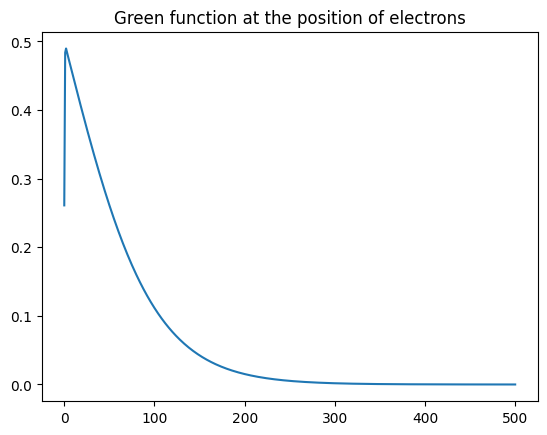

In [12]:
# # ------------ Load Green Function  ------------ #
G = np.load(GreenFuncName)

# here you can compare G with another Green function
plt.plot(G[position_of_electrons,0,:])
plt.title('Green function at the position of electrons')
plt.show()

In [13]:
dGr = np.zeros((N, N))
dGzTOP = np.zeros((N, N))
dGzBOTTOM = np.zeros((N, N))

# # ----------- Green function difference along the charge pool ----------- #
for n in range(0, N):
    for i in range(0, N):
        dGr[n,i] = -4*np.pi*e*(G[position_of_electrons,i+1,n]-G[position_of_electrons,i,n])
    
# # ----------- Green function difference across the cell's top ----------- #
        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz) #for testing
        

# # ----------- Green function difference across the cell's bottom ----------- #
        dGzBOTTOM[n,i] = -4 * np.pi * e * (G[1,i,n]-G[0,i,n])*(hr/hz)

## Choose the voltage sweep

In [18]:
Eztil = np.zeros(N+1)

Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Vit=0/300 #statvolt
Vmt=0/300 #statvolt
Vot=0/300 #statvolt

Vr=0/300 #statvolt

Vob=-20/300
Vmb=-20/300
Vib_start=3
Vib_stop=30
Vib_step=0.2
Vib = np.arange(Vib_start, Vib_stop, Vib_step)/300
print(len(Vib))



135


## Calculate $\tilde \Phi$ (if it is already calculated, do not run this code)

In [ ]:
def phitilGen():


    phitilInitial = fitilSOLUT(R,H,N,M,Vib[0],Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr)
    phitilList = np.array(np.zeros((len(Vib), np.shape(phitilInitial)[0], np.shape(phitilInitial)[1])))
  
    phitilList[0] = phitilInitial
    

    for i in range(1,len(Vib)):
        print(len(Vib) - i)
        print('Vib ='+str(Vib[i]*300))
        phitilList[i] = fitilSOLUT(R,H,N,M,Vib[i],Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr)

    return phitilList

## The code below can generate for different Vmb

In [29]:
folder = "VibSweep/"
for Vmb in [-15/300, -20/300, -30/300]:
    Vob=Vmb
    Vmb_str = f"m{abs(Vmb*300)}" if Vmb < 0 else f"{Vmb}"
    phitilList = phitilGen()
    PhiTilName = folder+f'Vmb_Vob{Vmb_str}V/Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(1e-10)) + '_Vib_step='+ str(Vib_step).replace('.','pt')+ '_Vib_start=' +str(Vib_start).replace('.','pt') +'_Vib_stop='+ str(Vib_stop).replace('.','pt') +  '_Vmb'+ str(int(Vmb*300))+ '_Vob'+ str(int(Vob*300)) +'.npy'
    fileName = folder + str(PhiTilName)
    np.save(fileName, phitilList)

0


KeyboardInterrupt: 

## Decide which Vmb and Vob values you will proceed with later.
## Load PhiTilList

In [31]:
Vob=-20/300
Vmb=-20/300
Vmb_str = f"m{int(abs(Vmb*300))}" if Vmb < 0 else f"{Vmb}"
print(Vmb_str)
folder = "VibSweep/"

fileName = folder+f'Vmb_Vob{Vmb_str}V/Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(1e-10)) + '_Vib_step='+ str(Vib_step).replace('.','pt')+ '_Vib_start=' +str(Vib_start).replace('.','pt') +'_Vib_stop='+ str(Vib_stop).replace('.','pt') +  '_Vmb'+ str(int(Vmb*300))+ '_Vob'+ str(int(Vob*300)) +'.npy'
print(fileName) 

phitilNump=np.load(fileName)
print(np.shape(phitilNump))

Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

m20
VibSweep/Vmb_Vobm20V/Phi_R0pt75_H0pt2_N500_M200_posiE100_epsE-10.0_Vib_step=0pt2_Vib_start=3_Vib_stop=30_Vmb-20_Vob-20.npy
(135, 201, 501)


## Saturated density profile

In [32]:
print(phitilNump.shape)
print(len(Vib))

(135, 201, 501)
135


In [34]:
preCalcDisStat = np.arange(1, N+1)


@jit(nopython = True, fastmath=True, parallel=True)
def distribSTATIC(R,H,N,M,G,Ertil,dGr,radius_of_electron_pool):

    dens = np.zeros(N+1)
    dens[:int(radius_of_electron_pool)+1] = np.dot(Ertil[:int(radius_of_electron_pool)+1], np.linalg.inv(dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]))

    A = np.zeros(N+1)

    A[0] = np.pi * np.power((hr/2), 2)
    A[N] = np.pi *(N - 5/4) * np.power(hr, 2)
    A[0:N] = 2 * np.pi * (preCalcDisStat - 1) * np.power(hr, 2)
    
    temp = A[0:len(dens)] * dens[0:len(dens)]
    
    N_total = np.sum(temp)
    
    return dens, N_total, A, temp

In [35]:
#for each potential, calculates the density profile (depeding on the radus of the electron pool)
Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)
print(len(phitilNump))    

N_total_list = np.zeros(len(phitilNump))
N_per_ring_list = np.zeros((len(phitilNump), N+1))
denList = np.zeros((len(phitilNump), N+1))
density_max_list = np.zeros(len(phitilNump))
R_star_list = np.zeros(len(phitilNump))
Ertil_list=np.zeros((len(phitilNump), N))
Eztil_list = np.zeros((len(phitilNump), N+1))

for l in range(0, len(phitilNump)):


    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]

        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz


    radius_of_electron_pool = np.round(0.4/hr)
    
    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])

    
    for k in range(0, len(radius_of_electron_pool_list)):

    

        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        

        # ------------- induced charge at the top inner electrode ------------------- #
        Ez = EztilTOP[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind=Qsum/e

        # ------------- induced charge at the bottom inner electrode ------------------- #
        Ez = EztilBOTTOM[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind = Qsum/e
        
        # ------------  potential at/below/above the electrons ------------ #


        copyAr2D(G_at_electrons, G[position_of_electrons].T)
        copyAr2D(G_below_electrons, G[position_of_electrons-1].T)
        copyAr2D(G_above_electrons, G[position_of_electrons+1].T)
        
        phi_at_electrons = phitil[position_of_electrons] - 4 * np.pi * e * hr * np.dot(density, G_at_electrons)
        phi_below_electrons = phitil[position_of_electrons-1] - 4 * np.pi * e * hr * np.dot(density, G_below_electrons)
        phi_above_electrons = phitil[position_of_electrons+1] - 4 * np.pi * e * hr * np.dot(density, G_above_electrons)

        # ---------- electric r-field across the liquid surface  ---------- #
        Er = np.zeros(N)

        Er[0:N] = (phi_at_electrons[0:N] - phi_at_electrons[1:N+1])/hr
        
        # ------------ electric field acting on electrons  ---------------- #
        Ezbelow[0:N+1] = (phi_below_electrons[0:N+1] - phi_at_electrons[0:N+1])/hz
        Ezabove[0:N+1] = (phi_at_electrons[0:N+1] - phi_above_electrons[0:N+1])/hz
        
        # adds the electric field acting on the electrons at the center to a list 
        Ezuplist[k] = Ezabove[0]
    
    
    minimum = np.amin(np.abs(Ezuplist))
    # chooses the index of the smallest absolute value of the electric field acting on the electrons at the center
    idx = np.argmin(np.abs(Ezuplist))

    # chooses the radius of the electron pool accordingly
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    #calculates the final density profile with the chosen radius of the electron pool
    # this is done for every potential in the Vob sweep
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
    
    # check eq 56 
    print(np.max(np.abs(np.dot(density[:int(radius_of_electron_pool)+1], dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]) -Ertil[:int(radius_of_electron_pool)+1])))
    
    N_total_list[l] = N_total
    print(N_total*1e-7)
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    N_per_ring_list[l] = N_per_ring
    Ertil_list[l]=Ertil
    Eztil_list[l] = Eztil

colors = plt.cm.jet(np.linspace(0,1,len(denList)))

print(N_total_list)




135
Iterations Left: 136
3.382710778154774e-17
0.28892147073366753
Iterations Left: 135
3.8163916471489756e-17
0.3219120415665595
Iterations Left: 134
3.122502256758253e-17
0.3583831521770736
Iterations Left: 133
3.469446951953614e-17
0.3858971486441425
Iterations Left: 132
3.8163916471489756e-17
0.41535882156622
Iterations Left: 131
5.377642775528102e-17
0.44689222755725716
Iterations Left: 130
4.5102810375396984e-17
0.4806277755980493
Iterations Left: 129
4.85722573273506e-17
0.5167022958933908
Iterations Left: 128
5.551115123125783e-17
0.5552591085642729
Iterations Left: 127
4.380176776841438e-17
0.5778713069217073
Iterations Left: 126
6.591949208711867e-17
0.6205882081177394
Iterations Left: 125
6.245004513516506e-17
0.6661829808581089
Iterations Left: 124
4.85722573273506e-17
0.6928691654178268
Iterations Left: 123
6.245004513516506e-17
0.7205123482504515
Iterations Left: 122
6.071532165918825e-17
0.7727315266386412
Iterations Left: 121
4.85722573273506e-17
0.8032328584584558
Iter

3.3306690738754696e-16
6.277317439446208
[ 2889214.70733668  3219120.4156656   3583831.52177074  3858971.48644143
  4153588.2156622   4468922.27557257  4806277.75598049  5167022.95893391
  5552591.08564273  5778713.06921707  6205882.08117739  6661829.80858109
  6928691.65417827  7205123.48250451  7727315.26638641  8032328.58458456
  8348059.17616358  8674819.50650263  9292097.95542771  9651693.22055917
 10023557.90771065 10408026.30057368 10805436.08780386 11216128.0973793
 11640445.97700103 12078735.20998177 12165890.72816478 12621118.22012413
 13091079.72189091 13576124.79981397 14076602.59631405 14174643.3984074
 14693796.2828219  15229146.69470251 15781038.42529119 15888026.24110707
 16459967.14530227 17049197.83173773 17162487.14013042 17772596.10686798
 18400721.95678852 18520603.64837014 19170470.92924341 19293761.94614511
 19965828.03402343 20092605.10682011 20787317.23103086 21501470.29690274
 21635451.28646581 22373030.89871767 22510729.60988467 23272142.48520964
 23413636.50

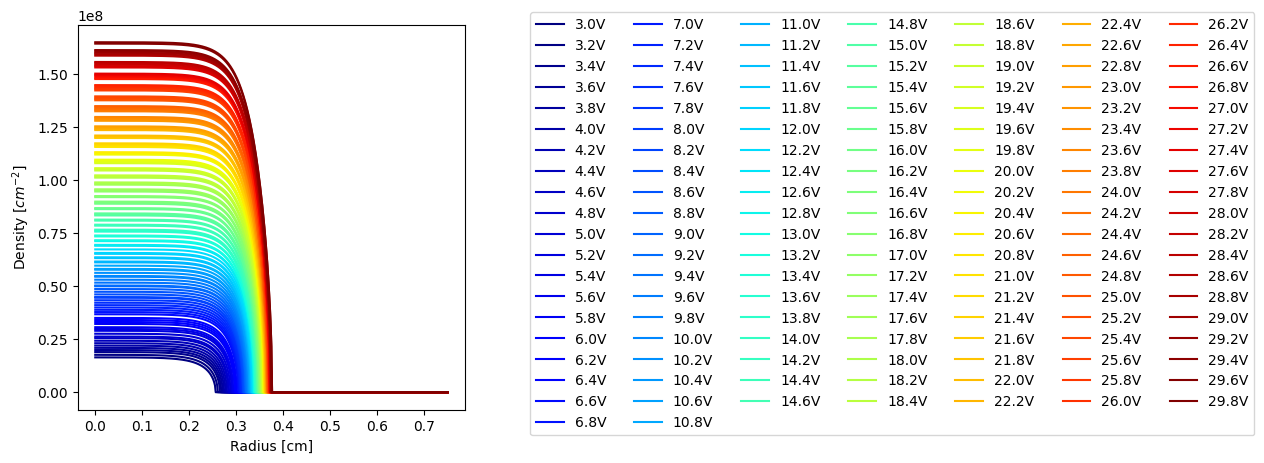

In [36]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), sharex=True)

for d in range(len(phitilNump)):
    ax.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(np.round(Vib[d] * 300,1))+'V')



ax.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
ax.set_ylabel(r"Density $[cm^{-2}]$")
# ax2.set_ylabel(r"$\tilde{E^r}$ [statV/cm]")
# ax2.set_ylabel(r"$\tilde{E^z}$ [statV/cm]")
ax.set_xlabel("Radius [cm]")
# ax2.set_xlabel("Radius [cm]")
plt.show()


### Run if you want to save the saturated densities

In [40]:
folder = "VibSweep/"

for idx in range(len(denList)):
    Vib_str = f"{Vib[idx] * 300:.1f}".replace(".", "p")
    # filename = f"DensityFiles/Saturated_density/saturated_density_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    #fileName = folder + f'Vmb_Vob{Vmb_str}V/saturated_density2/saturated_density_Vib{Vib_str}_Vob{int(Vob*300)}_Vmb{int(Vmb*300)}_N{N}_M{M}_posiE{position_of_electrons}.npy'
    fileName = folder + f'Vmb_Vob{Vmb_str}V/saturated_density/saturated_density_Vib{Vib_str}_Vob{int(Vob*300)}_Vmb{int(Vmb*300)}_N{N}_M{M}_posiE{position_of_electrons}.npy'
    print(fileName)
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(fileName, data_to_save)

VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib3p0_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib3p2_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib3p4_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib3p6_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib3p8_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib4p0_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib4p2_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib4p4_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib4p6_Vob-20_Vmb-20_N500_M200_posiE100.npy
VibSweep/Vmb_Vobm20V/saturated_density2/saturated_density_Vib4p8_Vob-20_Vmb-20_N50

## Fixed N Density List

In [41]:
Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)

N_Fixed_list = np.copy(N_total_list)

# fix the number of electrons to be equal to the number of electrons at Vob=-96V 
# indeed the sweep of Vob is done from -96V to -5.5V, so the number of electrons at Vob=-96V is the one that is fixed



N_Fixed = N_total_list[0]

for l in range(0, len(phitilNump)):
    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]



        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz

    
    radius_of_electron_pool = np.round(0.4/hr)
    print(radius_of_electron_pool)
    
    #radius_of_electron_pool_list = np.arange(radius_of_electron_pool - 350,radius_of_electron_pool+1)
    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])


    N_total_vect = np.zeros(len(radius_of_electron_pool_list))
    for k in range(0, len(radius_of_electron_pool_list)):
        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        N_total_vect[k] = N_total
    minimum = np.amin(np.abs(N_total_vect - N_Fixed))
    idx = np.argmin(np.abs(N_total_vect - N_Fixed))    

    
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)

    
    N_total_list[l] = N_total
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    print((N_total-N_Fixed)/N_Fixed)
    


Iterations Left: 136
267.0
0.0
Iterations Left: 135
267.0
0.008800198190513284
Iterations Left: 134
267.0
-0.015709849238582783
Iterations Left: 133
267.0
-0.007197890114094631
Iterations Left: 132
267.0
0.0013140113035422971
Iterations Left: 131
267.0
0.00982584781684642
Iterations Left: 130
267.0
-0.015076628816827574
Iterations Left: 129
267.0
-0.006844266514490045
Iterations Left: 128
267.0
0.0013880293950749227
Iterations Left: 127
267.0
0.009620255335725955
Iterations Left: 126
267.0
-0.01562603507507681
Iterations Left: 125
267.0
-0.00766476440057627
Iterations Left: 124
267.0
0.0002964527109500213
Iterations Left: 123
267.0
0.008257577211053396
Iterations Left: 122
267.0
0.016218645555307543
Iterations Left: 121
267.0
-0.009587907816138308
Iterations Left: 120
267.0
-0.0018895165297449508
Iterations Left: 119
267.0
0.005808780307681282
Iterations Left: 118
267.0
0.013507017585195544
Iterations Left: 117
267.0
-0.012545301066199187
Iterations Left: 116
267.0
-0.00510171057920052